In [1]:
# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
import pickle

/home/vincent/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

# Improved CICIDS2017

In [3]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df

    

In [4]:
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = ['monday.csv', 
                  'tuesday.csv', 
                  'wednesday.csv', 
                  'thursday.csv', 
                  'friday.csv']


def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
    dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']
    improved_df = clean_df(improved_df)
    improved_df.drop(dropping_cols, axis = 1, inplace = True)
    improved_df['Label'].value_counts()    
    return improved_df
improved_df = read_csv()

KeyboardInterrupt: 

In [ ]:
#### Sample out Malicious data such that it would become an outlier
print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
print(f'improved_df.shape {improved_df.shape} after Sampling Out')

improved_df.shape (2099971, 84) Before Sampling Out
improved_df.shape (1737784, 84) after Sampling Out


In [ ]:
ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

Ratio of Benign to Anomaly is 10.195402743150177 : 1


# Global, Local, and test split

Global: 40%, 
Label Propagation from Global: 40%, 
Evaluation: 20%

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()

In [ ]:
Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
X = improved_df.copy().drop(columns=["Label"], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

global_perc = 0.4
local_perc = 0.4
eval_perc = 0.2

# benign trainin and testing

X_train_global, X_local, y_train_global, y_local = train_test_split(X_scaled,
                                                    Y,
                                                    test_size = 1-global_perc, 
                                                    shuffle = True, 
                                                    stratify = Y, 
                                                    random_state = 0)
X_train_local, X_test, y_train_local, y_test = train_test_split(X_local,
                                                    y_local,
                                                    test_size = 1/3, 
                                                    shuffle = True, 
                                                    stratify = y_local, 
                                                    random_state = 0)




In [ ]:
print(f"Global Training: {X_train_global.shape[0]}, Local Training: {X_train_local.shape[0]}. Local Evaluation: {X_test.shape[0]}")

Global Training: 695113, Local Training: 695114. Local Evaluation: 347557


In [ ]:
y_train_global

301230     0.0
1296671    0.0
387518     0.0
1749352    0.0
2076930    0.0
          ... 
243399     0.0
1633001    0.0
326260     0.0
1705292    0.0
1867048    1.0
Name: Label, Length: 695113, dtype: float64

In [ ]:
from sklearn import metrics

def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)

# Global Model Training

In [65]:
# Reduce Labeled Data
frac = 0.05
idx = np.where(y_train_global == 1)[0]
y = np.zeros_like(y_train_global.values)
idx = np.random.choice(idx, int(len(idx)*frac), replace=False)

y[idx] = 1

In [13]:
from collections import Counter
Counter(y)

NameError: name 'y' is not defined

In [67]:
PReNet_clf = PReNet(device='cuda', verbose=1, epochs=5)
PReNet_clf.fit(X=X_train_global.to_numpy(), y = y_train_global)

Start Training...
ensemble size: 1


Epochs:  20%|██        | 1/5 [43:51<2:55:24, 2631.08s/it]

Epoch   1, Training Loss: 0.102042, Time: 2631.1s


Epochs:  80%|████████  | 4/5 [2:41:18<39:39, 2379.28s/it]  

In [ ]:
pred = PReNet_clf.predict(X_test.to_numpy())
get_score(pred, y_test)
print(y_test.value_counts())
anomaly_scores = PReNet_clf.decision_function(X_test.to_numpy())

Accuracy: 0.9799
Precision: 0.9861
Recall: 0.8233
F1 Score: 0.8974
[[309942    432]
 [  6570  30613]]
Label
0.0    316512
1.0     31045
Name: count, dtype: int64


In [36]:
model = PReNet() # or any other models in DeepOD

model = model.load_model("./PReNet_US_Best.pth")


AttributeError: 'PReNet' object has no attribute 'load_model'

In [27]:
from tensorflow.keras.models import load_model

# Replace 'path_to_my_model' with the path to your model file
# model = load_model('./PReNet_US_Best.pth')  # If your model is saved in HDF5 format
# or
model = load_model('PReNet_Best')  # If your model is saved in SavedModel format


OSError: Unable to synchronously open file (file signature not found)

<Figure size 1000x600 with 0 Axes>

(array([3.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00, 1.00000e+00,
        1.49000e+02, 2.30000e+01, 5.70000e+01, 3.52900e+03, 2.30000e+02,
        9.77000e+02, 4.51590e+04, 1.53100e+03, 7.14000e+03, 2.53425e+05,
        3.01300e+03, 5.97000e+02, 9.60000e+01, 8.10000e+01, 4.00000e+01,
        6.90000e+01, 3.60000e+01, 2.30000e+01, 1.70000e+01, 1.80000e+01,
        2.20000e+01, 2.40000e+01, 2.30000e+01, 1.80000e+01, 1.50000e+01,
        1.50000e+01, 8.00000e+00, 8.00000e+00, 5.00000e+00, 1.20000e+01,
        2.00000e+00, 4.00000e+00, 6.00000e+00, 3.00000e+00, 6.00000e+00,
        1.70000e+01, 7.00000e+00, 1.20000e+01, 9.00000e+00, 2.00000e+00,
        4.00000e+00, 4.00000e+00, 1.00000e+00, 7.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+01, 5.00000e+00, 4.00000e+00, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00, 4.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00

(array([5.0000e+00, 0.0000e+00, 2.6000e+01, 3.3000e+01, 6.0000e+00,
        3.0100e+02, 8.3000e+01, 5.0000e+00, 0.0000e+00, 4.0000e+00,
        7.0000e+00, 4.0000e+00, 2.5000e+01, 3.1000e+01, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00,
        4.0000e+00, 5.0000e+00, 8.0000e+00, 7.0000e+00, 9.0000e+00,
        8.0000e+00, 1.1000e+01, 1.0000e+01, 3.3000e+01, 3.4000e+01,
        3.0000e+01, 2.1200e+02, 2.6800e+02, 1.5200e+02, 2.9520e+03,
        1.4980e+03, 9.9300e+02, 2.0569e+04, 3.2230e+03, 2.7800e+02,
        4.7000e+01, 2.6000e+01, 3.3000e+01, 2.9000e+01, 1.5000e+01,
        6.0000e+00, 5.0000e+00, 2.0000e+00, 5.00

Text(0.5, 1.0, 'Distribution of Anomaly Scores')

Text(0.5, 0, 'Anomaly Score')

Text(0, 0.5, 'Frequency')

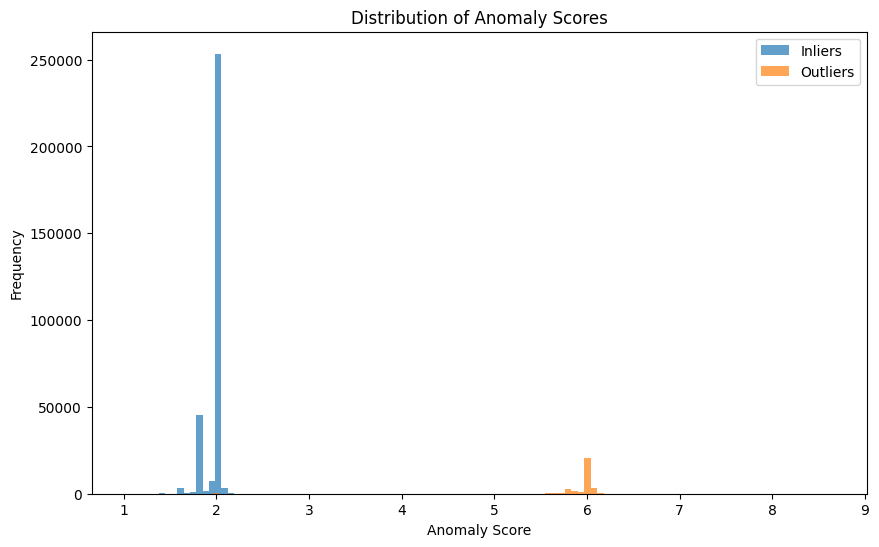

In [ ]:
# Separate anomaly scores based on the labels
scores_inliers = anomaly_scores[y_test == 0]  # Assuming '0' is the label for inliers
scores_outliers = anomaly_scores[y_test == 1]  # Assuming '1' is the label for outliers

# Create the plots
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot for inliers
plt.hist(scores_inliers, bins=100, alpha=0.7, label='Inliers')

# Plot for outliers
plt.hist(scores_outliers, bins=100, alpha=0.7, label='Outliers')

# Adding titles and labels
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Add a legend to the plot
plt.legend()
# plt.xlim(0,3)

# Show the plot
plt.show()

Get The ROC and AUC-ROC Curve

<Figure size 640x480 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

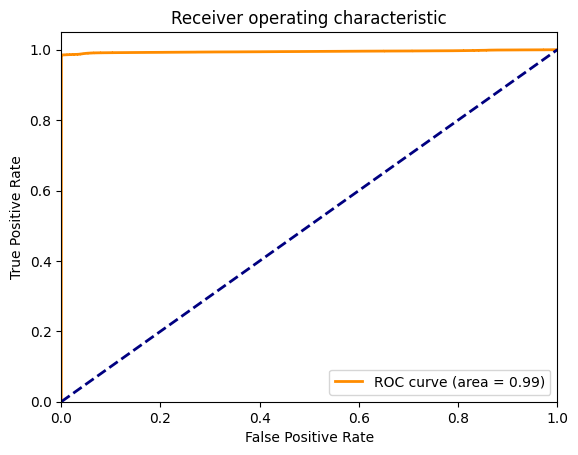

0.9948809268164236


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Example data
y_true = y_test
scores = anomaly_scores

fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve (optional)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(roc_auc)


<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall curve')

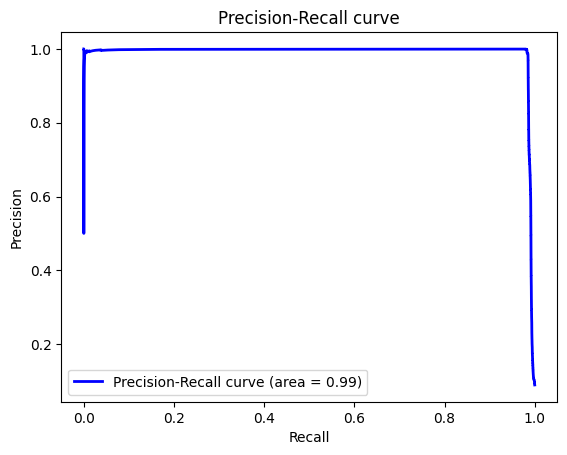

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, scores)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve (optional)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


In [ ]:
# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)


Optimal threshold: 4.653317451477051


# CART Transfer Learning

### Data Labeling with PReNEt

In [ ]:
anomaly_scores = PReNet_clf.decision_function(X_train_local.to_numpy())
pred = np.where(optimal_threshold>4.653,1,0)
# y_train_local = pred


In [ ]:
X_local = X_train_local.copy()
y_local = y_train_local.copy()

In [ ]:
test_perc = 0.2
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_local,
                                                    pred,
                                                    test_size = test_perc, 
                                                    shuffle = False, 
                                                    # stratify = pred, 
                                                    random_state = 0)
print(f"Shape of Training {X_train_local.shape[0]}, Shape of Testing {X_test_local.shape[0]}")

Shape of Training 556091, Shape of Testing 139023


### CART Training

In [14]:
CART = DecisionTreeClassifier()
CART.fit(X_train_local, y_train_local)


DecisionTreeClassifier()

In [15]:
# Labels are based on PReNet Prediciton
cart_pred = CART.predict(X_test_local)
get_score(cart_pred, y_test_local)


NameError: name 'X_test_local' is not defined

In [ ]:
# Labels are based on PReNet Prediciton
cart_pred = CART.predict(X_test)
get_score(cart_pred, y_test)


Accuracy: 0.9982
Precision: 0.9819
Recall: 0.9981
F1 Score: 0.9899
[[316454    563]
 [    58  30482]]


In [19]:

# Use X_train_global
CART.fit(X=X_train_global, y = y_train_global)
cart_pred = CART.predict(X_test)
get_score(cart_pred, y_test)
with open('decision_tree_classifier.pkl', 'wb') as file:
    pickle.dump(CART, file)

DecisionTreeClassifier()

Accuracy: 0.9997
Precision: 0.9989
Recall: 0.9982
F1 Score: 0.9985
[[316456     35]
 [    56  31010]]


In [20]:
with open('decision_tree_classifier.pkl', 'rb') as file:
  loaded_cart = pickle.load(file)
  
pred = loaded_cart.predict(X_test)
get_score(pred, y_test)

Accuracy: 0.9997
Precision: 0.9989
Recall: 0.9982
F1 Score: 0.9985
[[316456     35]
 [    56  31010]]
